In [2]:
import os
import cv2                                 # Image reading (as NumPy arrays)
from PIL import Image                      # Image reading via Pillow (optional for RGB mode)
import matplotlib.pyplot as plt            # Static plotting for histograms, line plots, etc.
import numpy as np                         # Numerical computations and array manipulation
from glob import glob                      # For recursive pattern-based file discovery
import pandas as pd                        # DataFrames for structured tabular data
import warnings                            # To suppress library warnings
warnings.filterwarnings('ignore') 

In [3]:
# Define the base directory where the dataset is located.
# This is the root directory that contains the three main tumor categories:
# - 'glioma'
# - 'meningioma'
# - 'tumor' (likely a general or mixed type)
base_dir = "/kaggle/input/brain-cancer-mri-colorized-dataset/data"

# List all subdirectories in the base directory.
# These represent the top-level classes (tumor types).
main_classes = os.listdir(base_dir)

# Display the names of the top-level folders (tumor categories).
main_classes

['brain_tumor', 'brain_glioma', 'brain_menin']

In [4]:
# Initialize a list to store image metadata
data = []

# Traverse each class folder
for main_class in main_classes:
    class_path = os.path.join(base_dir, main_class)

    # Traverse each augmentation subfolder (e.g., 'Edge_Detection', '3D_Rendering')
    for subfolder in os.listdir(class_path):
        subfolder_path = os.path.join(class_path, subfolder)

        # Check if the path is a directory (i.e., contains images)
        if os.path.isdir(subfolder_path):
            # Get all image files inside the augmentation subfolder
            image_files = glob(os.path.join(subfolder_path, '*.*'))  # Supports jpg, png, etc.

            # Append image details to the list
            for image_path in image_files:
                data.append({
                    'class': main_class,           # e.g., 'glioma'
                    'augmentation': subfolder,     # e.g., 'Edge_Detection'
                    'image_path': image_path       # Full image path
                })
# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df.head()

,class,augmentation,image_path
0,brain_tumor,LUT_Color_Map,/kaggle/input/brain-cancer-mri-colorized-datas...
1,brain_tumor,LUT_Color_Map,/kaggle/input/brain-cancer-mri-colorized-datas...
2,brain_tumor,LUT_Color_Map,/kaggle/input/brain-cancer-mri-colorized-datas...
3,brain_tumor,LUT_Color_Map,/kaggle/input/brain-cancer-mri-colorized-datas...
4,brain_tumor,LUT_Color_Map,/kaggle/input/brain-cancer-mri-colorized-datas...


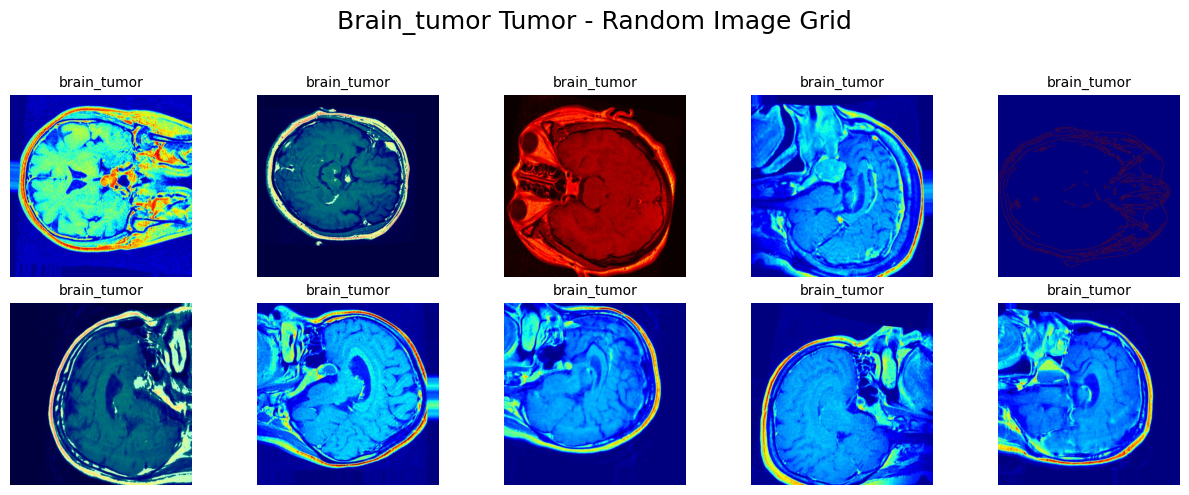

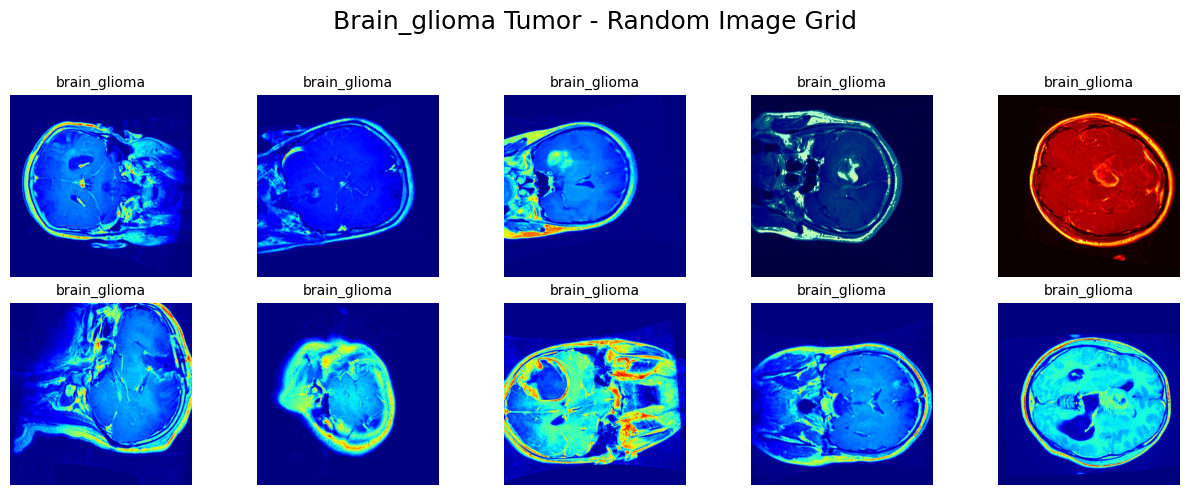

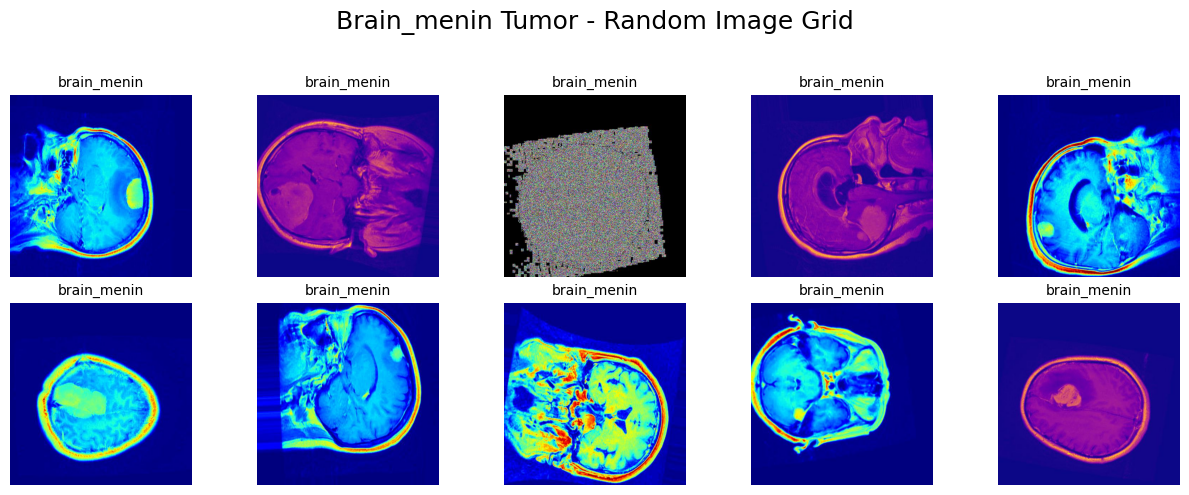

In [25]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def plot_random_grid(df, target_class, rows=2, cols=5):
    """
    Plots a grid of randomly selected images for a given class.
    
    Parameters:
    - df (DataFrame): DataFrame with image paths and class labels.
    - target_class (str): Class label to filter images (e.g., 'glioma').
    - rows (int): Number of rows in the grid.
    - cols (int): Number of columns in the grid.
    """
    num_images = rows * cols
    samples = df[df['class'] == target_class].sample(num_images)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    fig.suptitle(f'{target_class.capitalize()} Tumor - Random Image Grid', fontsize=18)
    
    # Flatten axes array for easy iteration (handles both 1D and 2D cases)
    axes = axes.flatten() if rows * cols > 1 else [axes]

    for i, ax in enumerate(axes):
        img = Image.open(samples.iloc[i]['image_path'])
        ax.imshow(img)
        ax.set_title(f"{target_class}", fontsize=10)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()

# Example: Loop through each tumor class and plot 10 images
for cls in df['class'].unique():
    plot_random_grid(df, cls, rows=2, cols=5)

In [7]:
# Import essential libraries
import torch
# PyTorch DataLoader utilities for batching, shuffling, splitting datasets
from torch.utils.data import DataLoader, random_split
# torchvision provides common image transformations and dataset loaders
from torchvision import datasets, transforms
# timm provides access to pre-trained Vision Transformer models and others
import timm
# Standard PyTorch modules for defining model architecture, loss, optimization
import torch.nn as nn
import torch.optim as optim
# tqdm provides progress bars for loops – especially useful during training
from tqdm import tqdm


In [8]:
# Define target input size for images (as expected by ViT models like ViT-B/16)
IMG_SIZE = 224

# Define a sequence of image transformations:
# - Resize: ensures all images are of the same size
# - ToTensor: converts PIL images to PyTorch tensors (C x H x W)
# - Normalize: standardize pixel values to [-1, 1] for faster & stable training
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),                            # Resize all images to 224x224
    transforms.ToTensor(),                                              # Convert to tensor format
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])     # Normalize RGB channels
])

# Define the root directory where your dataset is located
dataset_path = base_dir  # base_dir should point to the directory with 'glioma', 'meningioma', 'tumor' subfolders

# Load the dataset using ImageFolder:
# This assumes folder structure: root/class_name/image.jpg
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Get the class names detected by ImageFolder
class_names = full_dataset.classes
print("Classes:", class_names)  # Should print: ['glioma', 'meningioma', 'tumor']

# Split the dataset into training (80%) and validation (20%) sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Perform the split using random_split for reproducibility and randomness
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

Classes: ['brain_glioma', 'brain_menin', 'brain_tumor']


In [9]:
# Define the batch size for training and validation
BATCH_SIZE = 32

# Create the DataLoader for the training set
train_loader = DataLoader(
    train_dataset,           # Training dataset
    batch_size=BATCH_SIZE,   # Number of images per batch
    shuffle=True,            # Shuffle the dataset at every epoch for better generalization
    num_workers=4            # Number of subprocesses used for data loading (tune based on your hardware)
)
# Create the DataLoader for the validation set
val_loader = DataLoader(
    val_dataset,             # Validation dataset
    batch_size=BATCH_SIZE,   # Same batch size as training
    shuffle=False,           # Don't shuffle validation data
    num_workers=4            # Same number of workers as training
)

In [10]:
# Select the device to run the model on: GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
import torchvision.models as models

In [13]:
#  Load Pretrained ResNet and Modify
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 219MB/s]


In [15]:
num_classes = len(class_names)  # Get number of classes
model.fc = nn.Linear(num_features, num_classes)  

In [16]:
# Move the model to the selected device (GPU/CPU)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# Define the loss function for multi-class classification
criterion = nn.CrossEntropyLoss()
# Define the optimizer (AdamW is commonly used with transformers for better regularization)
optimizer = optim.AdamW(model.parameters(), lr=3e-5)

In [20]:
EPOCHS = 5  # Number of training epochs (increase as needed)

# Training Loop
for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    running_loss, correct = 0.0, 0  # Initialize loss and correct prediction counters

    # Iterate over batches in the training DataLoader
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)  # Move data to device (GPU/CPU)

        optimizer.zero_grad()  # Clear previous gradients before backpropagation
        outputs = model(images)  # Forward pass through the model
        loss = criterion(outputs, labels)  # Calculate loss between predicted and true labels
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights

        running_loss += loss.item()  # Accumulate loss for reporting
        correct += (outputs.argmax(1) == labels).sum().item()  # Count correct predictions in batch

    train_acc = correct / len(train_dataset)  # Calculate training accuracy
    print(f"Train Loss: {running_loss:.4f}, Accuracy: {train_acc:.4f}")  # Print training loss and accuracy

    # Validation Loop
    model.eval()  # Set model to evaluation mode (disables dropout, batchnorm updates)
    val_correct = 0  # Initialize correct prediction counter for validation

    with torch.no_grad():  # Disable gradient calculations for validation (saves memory)
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            outputs = model(images)  # Forward pass
            val_correct += (outputs.argmax(1) == labels).sum().item()  # Count correct predictions

    val_acc = val_correct / len(val_dataset)  # Calculate validation accuracy
    print(f"Validation Accuracy: {val_acc:.4f}")  # Print validation accuracy

Epoch 1/5: 100%|██████████| 1969/1969 [03:10<00:00, 10.34it/s]

Train Loss: 355.7442, Accuracy: 0.9268


Validation Accuracy: 0.9673


Epoch 2/5: 100%|██████████| 1969/1969 [02:41<00:00, 12.21it/s]

Train Loss: 155.2389, Accuracy: 0.9692


Validation Accuracy: 0.9705


Epoch 3/5: 100%|██████████| 1969/1969 [02:41<00:00, 12.17it/s]

Train Loss: 99.3932, Accuracy: 0.9802


Validation Accuracy: 0.9739


Epoch 4/5: 100%|██████████| 1969/1969 [02:41<00:00, 12.20it/s]

Train Loss: 70.4349, Accuracy: 0.9860


Validation Accuracy: 0.9742


Epoch 5/5: 100%|██████████| 1969/1969 [02:39<00:00, 12.37it/s]

Train Loss: 51.0565, Accuracy: 0.9904


Validation Accuracy: 0.9766


In [22]:
model.eval()  # Set model to evaluation mode
test_correct = 0
total = 0

with torch.no_grad():  # No gradient needed for evaluation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / total
print(f"\nTest Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9766


In [23]:
from collections import defaultdict

class_correct = defaultdict(int)
class_total = defaultdict(int)

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for label, prediction in zip(labels, predicted):
            class_total[label.item()] += 1
            if label.item() == prediction.item():
                class_correct[label.item()] += 1

# Print per-class accuracy
for i, class_name in enumerate(class_names):
    acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"Accuracy for class {class_name}: {acc:.4f}")


Accuracy for class brain_glioma: 0.9760
Accuracy for class brain_menin: 0.9709
Accuracy for class brain_tumor: 0.9826


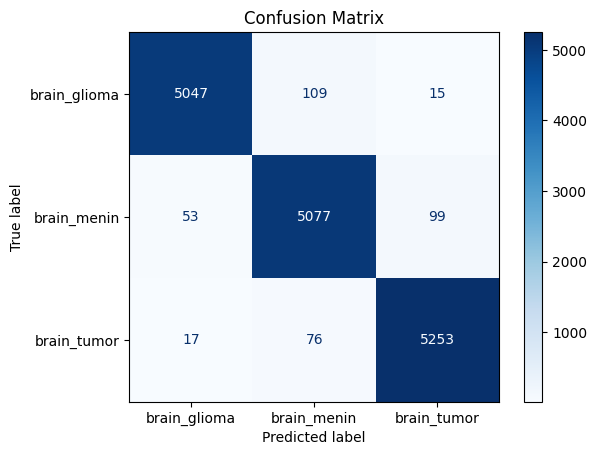

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()